# 미니 프로젝트 : CIFAR-100 이미지 생성

DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어보자.

## 0. 필요한 라이브러리 가져오기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


## 1. 데이터셋 구성

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


CIFAR-100 이미지 데이터는 32x32 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값을 가지며, RGB 3채널의 컬러 이미지이다.

### 정규화
이번 프로젝트에서는 CIFAR-100 데이터 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눈다.

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


### 데이터 확인

정규화된 데이터를 (0~255) 의 RBG 값을 가진 데이터로 변환하여 시각화하기 위해 `de_nomalize()` 함수를 구현한다.

In [5]:
def de_normalize(train):
    return (127.5 * train) + 127.5

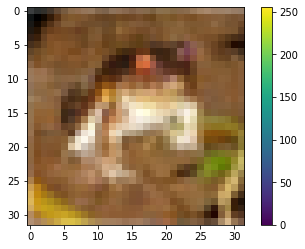

In [6]:
plt.imshow(de_normalize(train_x[0]).astype(np.int32).reshape(32, 32, 3))
plt.colorbar()
plt.show()

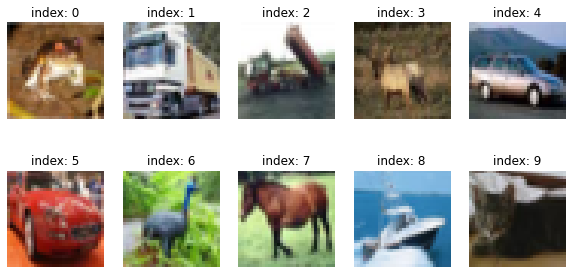

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(de_normalize(train_x[i]).astype(np.int32).reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

### 미니배치 데이터셋을 구성

tf.data.Dataset 모듈의 `from_tensor_slices()` 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다.  

시간 단축과 메모리 활용을 효율적으로 하기 위해 적절한 사이즈로 잘라서 학습을 진행하는 방식인 미니배치 학습 방식을 사용한다
- `BUFFER_SIZE` :  전체 데이터를 섞기 위해 50000 으로 설정
- `BATCH_SIZE` : 모델이 한 번에 학습할 데이터의 양

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

----
## 2. 생성자 (Generator) 구현

`make_generator_model` 이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 한다.

함수 내부에서는 먼저 `tf.keras.Sequential()` 로 모델을 시작한 후 레이어를 차곡차곡 쌓는다.

- 생성자의 입력 벡터
  - 모델은 입력값으로 (batch_size, 100) 형상의 노이즈 벡터를 받음  


- `Dense` 레이어
  - 처음 입력된(batch_size,100) 벡터는 4 x 4 x 256 = 4096개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 4096) 형상의 벡터가 됨  
  

- `Reshape` 레이어
  - 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (4, 4, 256) 형상의 3차원 벡터로 변환시킴  
  

- `Conv2DTranspose` 레이어
  - 가장 중요한 레이어
  - Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
  - 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (4, 4, 256) → (8, 8, 128) → (16, 16, 64) →  (32, 32, 3)순으로 이미지를 키워나감
  - 여기서 최종 사이즈인 (32, 32, 3)은 우리가 준비했던 데이터셋과 형상이 동일함  
  
  

- `BatchNormalization` 레이어
  - 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화  
  

- 중간층의 활성화 함수는 모두 `LeackyReLU` 를 사용  


- 마지막 층 활성화 함수로 `tanh` 사용
  -1~1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))


    return model

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

`noise = tf.random.normal([1, 100])`로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해보자.

In [12]:
noise = tf.random.normal([1, 100])


generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

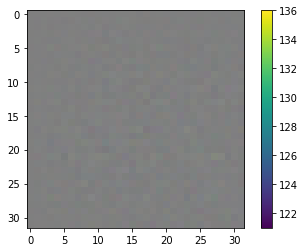

In [13]:
plt.imshow(de_normalize(generated_image[0].numpy()).astype(np.int32))
plt.colorbar()
plt.show()

----
## 3. 판별자 (Discriminator) 구현

Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나간다.

- 첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128) → (4, 4, 256) 까지 줄어들게 됨

- 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 4x4x256=4096, 즉 (1, 4096) 형상의 벡터로 변환한다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할

- 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Fourth: Flatten Layer
    model.add(layers.Flatten())

    # Fifth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

위에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해보자.

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00181533]], dtype=float32)>

----
## 4. 손실함수 (loss function) 와 최적화 함수 (Optimizer)

### 손실함수 (loss function)
GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다.  
판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용한다.  

교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있다.

- `from_logits`
  - `tf.keras.losses`의 `BinaryCrossEntropy` 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정
  - 따라서 `from_logit`s를 `True`로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있음

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy를 활용해 계산할 loss들은 `fake_output`와 `real_output`, 두 가지를 활용한다.
- `fake_output` : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 `D(fake_image)`
- `real_output` : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 `D(real_image)`

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- `generator_loss`
  - `fake_output`가 1에 가까워지기를 바라므로, `tf.ones_like`와의 교차 엔트로피값을 계산
  - cross_entropy(`tf.ones_like(fake_output)`, `fake_output`) 값은 `fake_output`이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가짐
  

- `discriminator_loss`
  - `real_output` 값은 1에 가까워지기를, `fake_output` 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산
  - `real_output`은 1로 채워진 벡터와, `fake_output`은 0으로 채워진 벡터와 비교
  - __최종 discriminator_loss 값은 이 둘을 더한 값__

### discriminator accuracy

- real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적
- fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻

In [19]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수(optimizer)
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

샘플은 한 번에 16장을 생성한다.  

생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야한다.  
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어둔다.

In [21]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

----
## 5. 훈련과정 설계

아래와 같은 과정을 통해 1개 미니배치의 훈련 과정을 처리하는 `train_step()` 함수를 구현해보자.  

- (1) __입력데이터__: Real Image 역할을 할 images 한 세트를 입력으로 받음


- (2) __생성자 입력 노이즈__ : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함


- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기


- (4) __generated_images 생성__ : generator가 noise를 입력받은 후 generated_images 생성


- (5) __discriminator 판별__ : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력


- (6) __loss 계산__ : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산


- (7) __accuracy 계산__ : fake_output, real_output으로 discriminator의 정확도 계산  


- (8) __gradient 계산__ : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산


- (9) __모델 학습__ : 계산된 gradient를 optimizer에 입력해 가중치 갱신  


- (10) __리턴값__ : 이번 스텝에 계산된 loss와 accuracy를 리턴  

In [22]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

다음으로, 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 `generate_and_save_images()` 함수를 구현해보자.

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(de_normalize(predictions[i, :, :, :].numpy()).astype(np.int32))
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples_0/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

다음으로, 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 `draw_train_history()` 함수를 구현해보자.

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history_0/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

마지막으로, training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 `checkpoint` 모듈을 설정한다.

`tf.train.Checkpoint`를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다.  
모델이 복잡해지고 학습 속도가 오래 걸릴수록, __모델에 대한 저장 및 버전 관리는 필수적__이다.

In [25]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_0'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

----
## 6. 모델 학습
지금까지 한 단계를 학습하는 `train_step`, 샘플 이미지를 생성하고 저장하기 위한 `generate_and_save_images()`, 학습 과정을 시각화하는 `draw_train_history()`, 그리고 모델까지 저장하기 위한 `checkpoint`까지 모두 준비가 되었으니 이것들을 한 곳에 합쳐서 최종 train 함수를 만들고 모델을 학습시킨다.

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 100

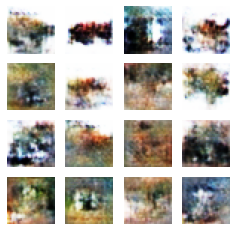

Time for training : 6229 sec


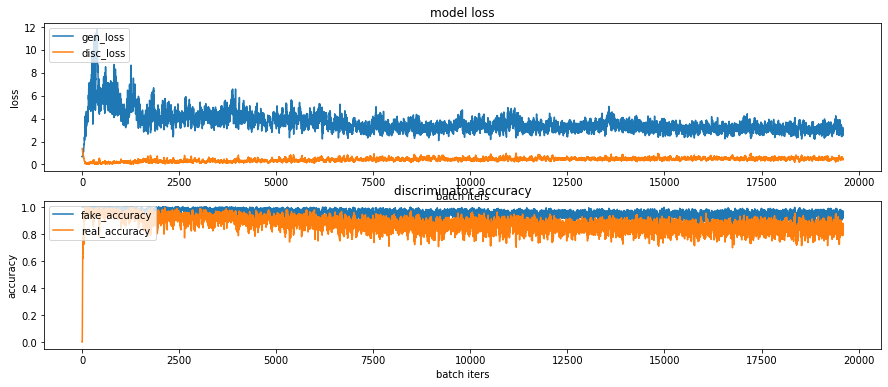

CPU times: user 1h 43min 12s, sys: 52.3 s, total: 1h 44min 5s
Wall time: 1h 43min 50s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

In [43]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_0.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples_0/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_0.gif

-rw-r--r-- 1 root root 1844513 Sep  2 12:45 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_0.gif


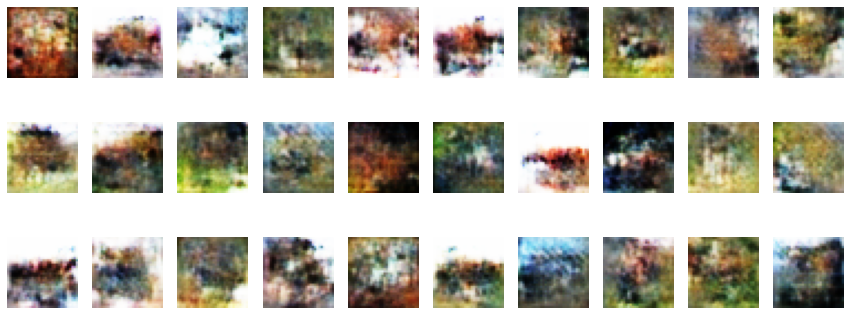

In [42]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_0'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 


for i in range(30):
    plt.subplot(3, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()  

![cifar10_dcgan_0](https://user-images.githubusercontent.com/84179578/131846227-717c8406-0721-4da5-bd6b-ea83ca0e3c4f.gif)
